# Recurrent Neural Networks

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Time series forecasting

In [3]:
from pandas.tseries.offsets import MonthEnd

df = pd.read_csv('F://tmp/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')

df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


In [4]:
split_date = pd.Timestamp('01-01-2011')

In [5]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

In [6]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [7]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)

for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [8]:
X_train.shape

(228, 12)



In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions



In [9]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [10]:
X_train_t.shape

(228, 12, 1)

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(12, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [15]:
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=0)

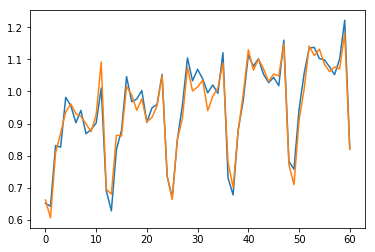

In [16]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)



RNN models can be applied to images 

- Load the MNIST data, by now you should be able to do it blindfolded :)
- reshape it so that an image looks like a long sequence of pixels
- create a recurrent model and train it on the training data




In [17]:
from keras.datasets import mnist
from keras.utils import to_categorical

In [18]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


11493376/11490434 [==============================] - 125s 11us/step


In [19]:
X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_test = X_test.reshape(X_test.shape[0], -1, 1)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(60000, 784, 1)
(10000, 784, 1)
(60000, 10)
(10000, 10)


In [ ]:
# define the model
K.clear_session()
model = Sequential()
model.add(LSTM(32, input_shape=X_train.shape[1:]))
model.add(Dense(10, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, y_train_cat,
          batch_size=32,
          epochs=100,
          validation_split=0.3,
          shuffle=True,
          verbose=2,
          )

model.evaluate(X_test, y_test_cat)